## Deep Learning to find the response of a Ballistic Composite

#### Imports needed for DL and handling of data

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#### Reading of CSV file with all pre-calculated data for composites

In [2]:
composites_data = pd.read_csv("./data/all_data_2.csv")
composites_data.drop(composites_data.iloc[:, 0:12], inplace = True, axis = 1)
composites_data.drop(composites_data.iloc[:, 6:12], inplace = True, axis = 1)
composites_data.drop(composites_data.iloc[:, 12:-1], inplace = True, axis = 1)
composites_data.drop(["L2_sf_t", "L2_sf_c", "L2_rel", "L4_E", "L4_rho", "L4_sf_t", "L4_sf_c", "L4_rel", "L2_rho"], inplace=True, axis=1)
composites_data.head()

,L2_h,L2_E,L4_h,Y
0,0.501944,18000000.0,0.303293,1
1,0.501944,18000000.0,0.303293,1
2,0.501944,18000000.0,0.303293,1
3,0.501944,18000000.0,0.312042,1
4,0.501944,18000000.0,0.312042,1


#### Pre-processing of data and definition of the Model to train

In [32]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical, normalize

#Split data into training and testing data
train_data = composites_data.sample(frac=0.8, random_state=123)
test_data = composites_data.drop(train_data.index)

#As all data is numeric, we can create a numpy array for all the x features (to make the operations faster) and we 
#can manually create the label y vector
def get_numpy(data):
    data_features = data.copy()
    data_labels = np.array(data_features.pop('Y'))
    data_features = np.array(data_features)
    return data_features, data_labels

comp_features_train, comp_labels_train = get_numpy(train_data)
comp_features_test, comp_labels_test = get_numpy(test_data)

#As every column doesn't have the same range and scale, it's useful to normalize the data using the Normalization layer
#provided by the layers module
comp_features_train = normalize(comp_features_train, axis=0)
comp_features_test = normalize(comp_features_test, axis=0)

#Number of True and False labels in the Test set
print("Percentage of true labels: ",np.sum(comp_labels_test)/len(comp_labels_test))
print("Percentage of false labels: ",np.sum(comp_labels_test == 0)/len(comp_labels_test))

Percentage of true labels:  0.5533707865168539
Percentage of false labels:  0.44662921348314605


In [41]:
## NN MODEL
#Model -> We will use a network with 1 hidden layer with 64 neurons on it. The final activation function will be a sigmoid
#function (to binary classify the composites), we will use the Adam optimizer algorithm and we will use a Mean Squared Error
#loss function. We keep track of the accuracy during the training process
composites_model = tf.keras.Sequential([
    #layers.LayerNormalization(),
    layers.Dense(256, input_shape=(comp_features_train.shape[1],), activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(2, activation="softmax")
])

opt = Adam(learning_rate=0.003)
composites_model.compile(loss = "sparse_categorical_crossentropy",
                           optimizer = opt, metrics=["accuracy"])
composites_model.summary()

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 256)               1024      
_________________________________________________________________
dense_29 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 130       
Total params: 42,306
Trainable params: 42,306
Non-trainable params: 0
_________________________________________________________________


#### Model fit with training data

In [42]:
#For training, 20 epochs will be used and callback is used to stop training when a given accuracy is reached (99.9%)
callbacks = myCallback()
history = composites_model.fit(comp_features_train, comp_labels_train, epochs=20, batch_size=32, 
                     callbacks=[callbacks], validation_data=(comp_features_test, comp_labels_test))

Train on 1426 samples, validate on 356 samples
Epoch 1/20
1426/1426 [==============================] - 1s 451us/sample - loss: 0.5917 - accuracy: 0.7069 - val_loss: 0.3108 - val_accuracy: 0.8792
Epoch 2/20
1426/1426 [==============================] - 0s 109us/sample - loss: 0.3191 - accuracy: 0.8857 - val_loss: 0.3204 - val_accuracy: 0.8624
Epoch 3/20
1426/1426 [==============================] - 0s 118us/sample - loss: 0.2730 - accuracy: 0.8885 - val_loss: 0.1830 - val_accuracy: 0.8792
Epoch 4/20
1426/1426 [==============================] - 0s 112us/sample - loss: 0.2833 - accuracy: 0.8850 - val_loss: 0.2290 - val_accuracy: 0.8792
Epoch 5/20
1426/1426 [==============================] - 0s 112us/sample - loss: 0.2469 - accuracy: 0.8955 - val_loss: 0.2946 - val_accuracy: 0.9045
Epoch 6/20
1426/1426 [==============================] - 0s 110us/sample - loss: 0.2239 - accuracy: 0.8962 - val_loss: 0.2290 - val_accuracy: 0.9326
Epoch 7/20
1426/1426 [==============================] - 0s 111us/

In [35]:
y = composites_model.predict(comp_features_test)
print(y)

[[0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.003 0.997]
 [0.003 0.997]
 [0.004 0.996]
 [0.004 0.996]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.004 0.996]
 [0.004 0.996]
 [0.003 0.997]
 [0.003 0.997]
 [0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.004 0.996]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.003 0.997]
 [0.002 0.998]
 [0.002 0.998]
 [0.014 0.986]
 [0.011 0.989]
 [0.011 0.989]
 [0.011 0.989]
 [0.01  0.99 ]
 [0.017 0.983]
 [0.015 0.985]
 [0.014 0.986]
 [0.014 0.986]
 [0.013 0.987]
 [0.011 0.989]
 [0.01  0.99 ]
 [0.009 0.991]
 [0.009 0.991]
 [0.009 0.991]
 [0.013 0.

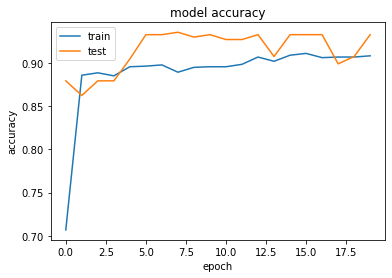

In [43]:
#Plot history of model!
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()